In [42]:
#GAN for image generation
#https://www.youtube.com/watch?v=ABaZ_tecZ3U&list=PLWKjhJtqVAbm3T2Eq1_KgloC7ogdXxdRa&index=6

import os
import torch
import torchvision
import torchvision.transforms as tt
from torchvision import transforms
import tarfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

%matplotlib inline

In [22]:
 #Get the parent directory and enter files
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '\\data_source\\anime-faces-images'


print(os.listdir(DATA_DIR +'\\images')[:10])

['10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg', '10009_2004.jpg']


In [23]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    #tt.RandomHorizontalFlip(),
    #tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    tt.Resize((image_size, image_size)),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size,shuffle=True, num_workers=4, pin_memory = True)

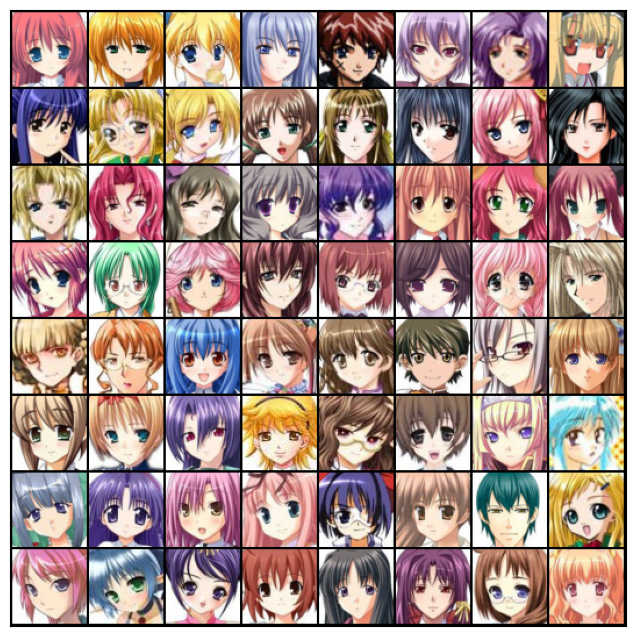

In [24]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)


In [25]:
#Utilize GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    "Wrap a dataloader to move data to a device"
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
print("device: ", device)

train_dl = DeviceDataLoader(train_dl, device)

device:  cuda


In [5]:
# ------------------------------
# Mapping Network
# ------------------------------
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim, num_layers):
        super(MappingNetwork, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(latent_dim, latent_dim))
            layers.append(nn.LeakyReLU(0.2))
        self.mapping = nn.Sequential(*layers)

    def forward(self, z):
        return self.mapping(z)

# ------------------------------
# Adaptive Instance Normalization (AdaIN)
# ------------------------------
def adain(x, style):
    mean = x.mean(dim=[2, 3], keepdim=True)
    std = x.std(dim=[2, 3], keepdim=True)
    style_mean, style_std = style.chunk(2, dim=1)
    style_mean = style_mean.unsqueeze(-1).unsqueeze(-1)
    style_std = style_std.unsqueeze(-1).unsqueeze(-1)
    return style_std * (x - mean) / (std + 1e-8) + style_mean

# ------------------------------
# StyleGAN Generator
# ------------------------------
class StyleGANGenerator(nn.Module):
    def __init__(self, latent_dim, img_channels, base_channels):
        super(StyleGANGenerator, self).__init__()
        self.latent_dim = latent_dim

        # Mapping Network
        self.mapping = MappingNetwork(latent_dim, num_layers=8)

        # Fixed starting input
        self.constant_input = nn.Parameter(torch.randn(1, base_channels, 4, 4))

        # Progressive layers
        self.prog_blocks = nn.ModuleList([
            GeneratorBlock(base_channels // (2**i), base_channels // (2**(i + 1)), latent_dim)
            for i in range(4)  # 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64
        ])

        # Final RGB conversion layer
        self.to_rgb = nn.Conv2d(base_channels // (2**(4)), img_channels, kernel_size=1)

    def forward(self, z):
        style = self.mapping(z)
        x = self.constant_input.repeat(z.size(0), 1, 1, 1)  #creates batch number of constant_input

        # Pass through progressive blocks
        for block in self.prog_blocks:
            x = block(x, style)

        # Final RGB conversion
        rgb = self.to_rgb(x)

        return torch.tanh(rgb)


# ------------------------------
# Generator Block
# ------------------------------
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, style_dim):
        super(GeneratorBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.style1 = nn.Linear(style_dim, out_channels * 2)
        self.style2 = nn.Linear(style_dim, out_channels * 2)
        self.noise1 = nn.Parameter(torch.randn(1, out_channels * 2 , 1, 1))
        self.noise2 = nn.Parameter(torch.randn(1, out_channels , 1, 1))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, style):
        x = self.upsample(x)
        noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=device)  # Noise for first layer
        style1 = self.style1(style)
        # print("x.shape: ", x.shape)
        # print("noise.shape: ", noise.shape)
        # print("self.noise1.shape: ",self.noise1.shape)  #!!!
        # print("style1.shape: ", style1.shape)
        x = adain(F.leaky_relu(self.conv1(x + self.noise1 * noise), 0.2), style1)

        noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=device)  # Noise for second layer
        style2 = self.style2(style)
        # print("x.shape: ", x.shape)
        # print("noise.shape: ", noise.shape)
        # print("self.noise2.shape: ",self.noise2.shape)  #!!!
        # print("style2.shape: ", style2.shape)
        x = adain(F.leaky_relu(self.conv2(x + self.noise2 * noise), 0.2), style2)

        return x



In [4]:
# ------------------------------
# StyleGAN Discriminator
# ------------------------------
class StyleGANDiscriminator(nn.Module):
    def __init__(self, img_channels, base_channels):
        super(StyleGANDiscriminator, self).__init__()

        # Progressive blocks
        self.prog_blocks = nn.ModuleList([
            DiscriminatorBlock(base_channels // (2**i), base_channels // (2**(i + 1)))
            for i in range(4)  # For 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4
        ])

        # From RGB conversion layer
        self.from_rgb = nn.Conv2d(img_channels, base_channels, kernel_size=1)

        # Final layer
        self.final_conv = nn.Conv2d(base_channels // (2**4), 1, kernel_size=4)

    def forward(self, x):
        x = self.from_rgb(x)
        for block in self.prog_blocks:
            x = block(x)
        x = self.final_conv(x)
        return x.view(x.size(0))  # Flatten to [batch_size]


# ------------------------------
# Discriminator Block
# ------------------------------
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscriminatorBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.downsample = nn.AvgPool2d(2)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.downsample(x)
        return x



In [8]:
"""
1-Adversarial Loss: Use Wasserstein Loss with Gradient Penalty for stability
2-Gradient Penalty: Penalize gradients of the discriminator to enforce Lipschitz continuity
"""

def gradient_penalty(D, real_images, fake_images, device):
    batch_size, C, H, W = real_images.size()
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated.requires_grad_(True)
    interpolated_score = D(interpolated)
    grad_outputs = torch.ones_like(interpolated_score, device=device)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

In [9]:
"""R1 Regularization instead of Gradient Penalty"""
def r1_regularization(real_images,real_scores,device):
    real_images.requires_grad_(True)
    grad_outputs=torch.ones_like(real_scores, device=device)
    gradients = torch.autograd.grad(
        outputs=real_scores,
        inputs=real_images,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(real_images.size(0), -1)
    return (gradients.norm(2, dim=1) ** 2).mean()

In [10]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

def save_images(images,index, show = True):
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images.cpu().detach(), nrow=8).permute(1,2,0))

In [11]:
#Training Loop

def train_stylegan(generator, discriminator, dataloader, epochs, latent_dim, device):
    torch.cuda.empty_cache()

    g_loss_history = []
    d_loss_history = []
    real_scores_history = []
    fake_scores_history = []

    # Optimizers
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.0, 0.99))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.0, 0.99))

    # Loss weights
    gradient_penalty_weight = 10.0
    r1_penalty_weight = 10.0

    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            #Adding noise to obtain stochastic features
            #real_images = real_images + torch.randn_like(real_images) * 0.05
            real_images = real_images.to(device)
            real_images.requires_grad_(True)
            # ------------------------------
            # Train Discriminator
            # ------------------------------
            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z)

            #Adding noise to obtain stochastic features
            #fake_images = fake_images + torch.randn_like(fake_images) * 0.05 

            real_scores = discriminator(real_images)
            fake_scores = discriminator(fake_images.detach())

            #gp = gradient_penalty(discriminator, real_images, fake_images, device)
            #d_loss = (-1.0) * real_scores.mean() + fake_scores.mean() + gradient_penalty_weight * gp

            r1 = r1_regularization(real_images, real_scores, device)
            d_loss = (-1.0) * real_scores.mean() + fake_scores.mean() + r1_penalty_weight/2 * r1

            #print("Discriminator - r1: ", r1, " real_scores.mean(): ", real_scores.mean(), " fake_scores.mean(): ", fake_scores.mean(), " d_loss: ", d_loss) #!!!

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # ------------------------------
            # Train Generator
            # ------------------------------
            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z)


            #Adding noise to obtain stochastic features
            #fake_images = fake_images + torch.randn_like(fake_images) * 0.05

            fake_scores = discriminator(fake_images)

            g_loss = (-1.0) * fake_scores.mean()

            #print("Generator - g_loss: ", g_loss)   #!!!

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()


        #Record losses & scores
        g_loss_history.append(g_loss)
        d_loss_history.append(d_loss)
        real_scores_history.append(real_scores.mean())
        fake_scores_history.append(fake_scores.mean())

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        print("r1: ", r1.item(), " real_scores.mean(): ", real_scores.mean().item(), " fake_scores.mean(): ", fake_scores.mean().item())

        # Save generated images
        save_images(fake_images, epoch, show=False)
    
    return g_loss_history, d_loss_history, real_scores_history, fake_scores_history


In [ ]:
# Initialize models
latent_dim = 512
img_channels = 3
base_channels = 512
epochs = 150

generator = StyleGANGenerator(latent_dim, img_channels, base_channels).to(device)
discriminator = StyleGANDiscriminator(img_channels, base_channels).to(device)

# Train
history = train_stylegan(
    generator=generator,
    discriminator=discriminator,
    dataloader=train_dl,
    epochs=epochs,
    latent_dim=latent_dim,
    device=device
)


In [ ]:
d_losses = history[0]
g_losses = history[1]

d_losses = [tensor.detach().cpu().numpy() for tensor in d_losses]
g_losses = [tensor.detach().cpu().numpy() for tensor in g_losses]

plt.plot(d_losses,'-')
plt.plot(g_losses,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

In [ ]:
real_scores_mean = history[2]
fake_scores_mean = history[3]

real_scores_mean = [tensor.detach().cpu().numpy() for tensor in real_scores_mean]
fake_scores_mean = [tensor.detach().cpu().numpy() for tensor in fake_scores_mean]

plt.plot(real_scores_mean,'-')
plt.plot(fake_scores_mean,'-')
plt.xlabel('epoch')
plt.ylabel('lscore')
plt.legend(['Real','Fake'])
plt.title('Scores')


In [15]:
# Save the generator and discriminator state dictionaries
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [ ]:
#Load the saved models

# Initialize models
latent_dim = 512
img_channels = 3
base_channels = 512

device = "cuda"

generator = StyleGANGenerator(latent_dim, img_channels, base_channels).to(device)
discriminator = StyleGANDiscriminator(img_channels, base_channels).to(device)

# Load the state dictionaries
generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))

# Ensure the models are in evaluation mode (optional for inference)
generator.eval()
discriminator.eval()



C:\Users\HP\AppData\Local\Temp\ipykernel_10784\3792464041.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))
C:\User

StyleGANDiscriminator(
  (prog_blocks): ModuleList(
    (0): DiscriminatorBlock(
      (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (1): DiscriminatorBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): DiscriminatorBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (3): DiscriminatorBlock(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_siz

torch.Size([3, 64, 64])

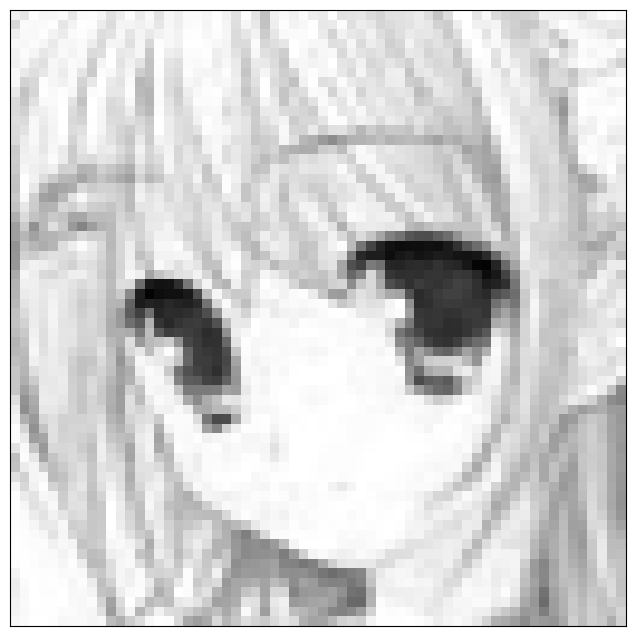

In [109]:
# Assuming you have a DataLoader called dataloader
data_iter = iter(train_dl)       # Create an iterator from the DataLoader
first_batch = next(data_iter)     # Fetch the first batch

# Unpack the images and labels (if labels are provided)
images, labels = first_batch

# Access the first image in the batch
first_image = images[0]
first_label = labels[0]  # Corresponding label

#Show the first image in the dataloader
plt.imshow(first_image.to("cpu").permute(1, 2, 0))

first_image.shape


torch.Size([64, 3, 64, 64])

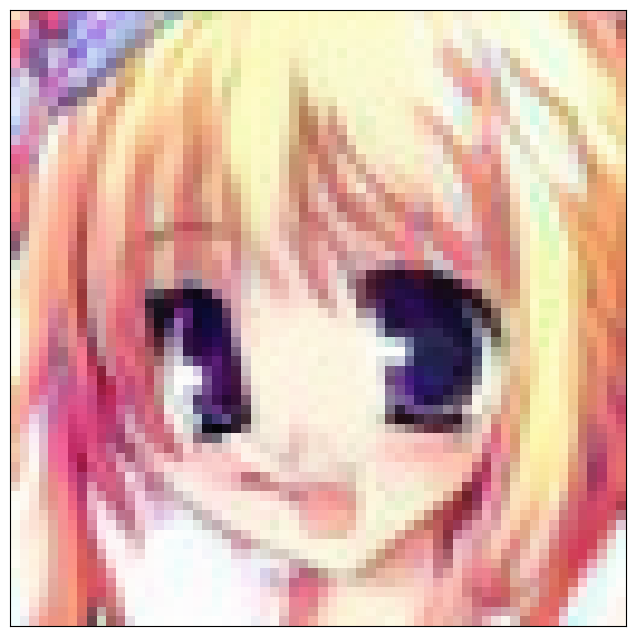

In [110]:
#Create an image using generator of Style GAN

#Create latent input (gaussian noise image)
z = torch.randn(64, latent_dim, device=device)

#Create fake image 
fake_image = generator(z)

show_images(fake_image.to("cpu"), nmax=1)

fake_image.shape